<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/Table%20Transformer/Using_Table_Transformer_for_table_detection_and_table_structure_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table Transformer: inference notebook

In this notebook, we are going to run the Table Transformer - which is actually a [DETR](https://arxiv.org/abs/2005.12872) model - by Microsoft Research (which is part of 🤗 Transformers) to perform table detection and table structure recognition on documents.

### Quick intro: DETR
DETR is short for DEtection TRansformer, and consists of a convolutional backbone (ResNet-50 or ResNet-101) followed by an encoder-decoder Transformer. It can be trained end-to-end to perform object detection (and panoptic segmentation, for that see my other notebooks in my repo [Transformers-tutorials](https://github.com/NielsRogge/Transformers-Tutorials)).The main contribution of DETR is its simplicity: compared to other models like Faster R-CNN and Mask R-CNN, which rely on several highly engineered things like region proposals, non-maximum suppression procedure and anchor generation, DETR is a model that can simply be trained end-to-end, and fine-tuned just like you would fine-tune BERT. This is possible due to the use of a clever loss function, the so-called **bipartite matching loss**. I highly recommend [Yannic Kilcher's video](https://www.youtube.com/watch?v=T35ba_VXkMY&t=1693s) if you want to understand how the full model works. 

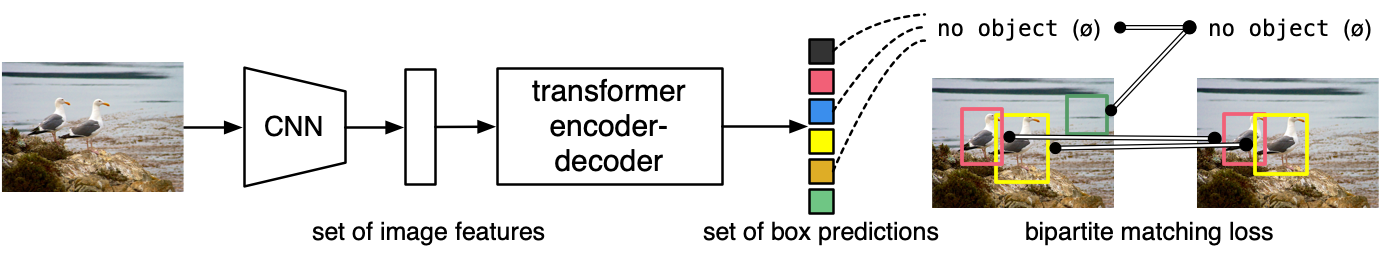

* Table Transformer paper: https://arxiv.org/abs/2110.00061
* DETR Paper: https://arxiv.org/abs/2005.12872
* DETR Blog post: https://ai.facebook.com/blog/end-to-end-object-detection-with-transformers/
* Official Github repository: https://github.com/facebookresearch/detr

My other DETR notebooks (which showcase how you can fine-tune DETR on a custom dataset, both for object detection and panoptic segmentation) can be found [here](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/DETR). 


In [ ]:
!pip install transformers

In [ ]:
!pip install -q timm

## Table detection

Table detection is the task of - you guessed it - detect tables in document images, like PDFs.

Let's load a PDF and see how our model does.

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image

file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_pdf.png")
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

Let's first apply the regular image preprocessing using `DetrFeatureExtractor`. The feature extractor will resize the image (minimum size = 800, max size = 1333), and normalize it across the channels using the ImageNet mean and standard deviation.

In [ ]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

In [ ]:
print(encoding['pixel_values'].shape)

## Forward pass

Next, let's send the pixel values and pixel mask through the model. We first load the model from the hub, and perform a forward pass.

In [ ]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

In [ ]:
import torch

with torch.no_grad():
    outputs = model(**encoding)

Let's visualize the results!

In [ ]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
# rescale bounding boxes
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

In [ ]:
plot_results(image, results['scores'], results['labels'], results['boxes'])

Cool! Seems like our model has correctly identified the single table present in the PDF.

## Table structure recognition

Table structure recognition is the task of identifying the several rows, columns, cells in a table.

Let's load a demo table (which I took from the [paper](https://openaccess.thecvf.com/content/CVPR2022/html/Smock_PubTables-1M_Towards_Comprehensive_Table_Extraction_From_Unstructured_Documents_CVPR_2022_paper.html)) and see how our model does.

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image

file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_table.png")
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

Let's prepare the image for the model using `DetrFeatureExtractor`.

In [ ]:
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

Let's load the model from the hub, and perform a forward pass.

In [ ]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

In [ ]:
with torch.no_grad():
    outputs = model(**encoding)

Let's visualize the results!

In [ ]:
target_sizes = [image.size[::-1]]
print('target_sizes:', target_sizes)
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
print(results['scores'].shape)
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [ ]:
model.config.id2label